# Part 1: Species Clustering for Syndrome Identification

This notebook implements **species clustering** to identify candidate syndromes by finding distantly related species that cluster together phenotypically.

## Strategy:
1. Cluster species based on traits
2. Check if clusters contain phylogenetically distant species
3. Identify traits driving the clustering
4. Generate candidate syndromes for further testing


## Step 1: Load Data and Libraries
This loads the fly trait data and imports necessary libraries for clustering and visualization.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from Bio import Phylo
import umap
import hdbscan
from scipy.spatial.distance import pdist, squareform

# Load data
df = pd.read_csv("../data/master.dataset.final.v2.csv")
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='all')

# Load phylogenetic tree
tree = Phylo.read("../data/FlyTree.tre", "newick")

df


,Species,th.len.m,th.len.m_se,th.wid.m,th.wid.m_se,th.hei.m,th.hei.m_se,th.vol.m,th.vol.m_se,wing.area.m,...,std.aging.rate.m,life.expectancy.f,life.expectancy.m,net.repro.output,early.repro.output,std.sex.siz.diff,std.aging.rate.bias,life.expectancy.bias,anisogamy,OSR
0,C_procnemis,0.985,0.007,0.683,0.005,0.908,0.009,0.612,0.003,1.360,...,4.39,86.947,122.764,166.0,44.0,-0.002,0.612,-0.498,0.000,-0.498
1,D_acutilabella,1.008,0.006,0.773,0.007,0.955,0.015,0.743,0.005,1.432,...,1.71,9.344,11.576,69.0,25.0,0.278,0.052,-0.309,0.000,2.736
2,D_affinis,0.865,0.007,0.628,0.008,0.850,0.016,0.461,0.004,1.229,...,1.98,73.782,135.774,51.0,29.0,0.335,0.559,-0.880,0.004,1.066
3,D_albomicans,1.250,0.042,0.808,0.009,1.048,0.013,1.057,0.013,1.902,...,4.22,55.969,21.319,343.0,122.0,0.245,-0.294,1.393,0.001,4.032
4,D_aldrichi,1.023,0.013,0.760,0.009,0.975,0.011,0.758,0.005,1.777,...,4.34,88.499,100.969,261.0,122.0,0.274,0.223,-0.190,0.001,0.503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Z_ghesquierei,1.160,0.013,0.750,0.004,1.055,0.008,0.918,0.004,1.803,...,1.41,307.698,286.228,252.0,63.0,0.211,-0.104,0.104,0.000,3.149
145,Z_indianus,1.190,0.005,0.808,0.006,1.095,0.006,1.052,0.004,2.029,...,4.00,253.156,334.804,481.0,265.0,-0.064,0.371,-0.403,0.003,-0.403
146,Z_kolodkinae,1.298,0.026,0.968,0.021,1.216,0.026,1.529,0.018,2.120,...,2.89,105.269,80.928,250.0,124.0,0.163,-0.242,0.379,0.001,0.379
147,Z_taronus,1.349,0.007,0.908,0.009,1.260,0.008,1.544,0.007,1.992,...,3.95,310.840,358.722,572.0,267.0,-0.073,0.270,-0.207,0.005,2.432


## Step 2: Prepare Trait Data
This cleans the data by removing standard error columns and handling missing values, then standardizes all traits for fair comparison.


In [3]:
# Prepare numeric trait data (exclude standard error columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns
trait_cols = [col for col in numeric_cols if not col.endswith('_se')]
trait_data = df[trait_cols].copy()

# Handle missing values
trait_data_clean = trait_data.fillna(trait_data.mean())

# Standardize traits (mean=0, std=1)
scaler = StandardScaler()
trait_scaled = scaler.fit_transform(trait_data_clean)

print(f"Prepared {len(trait_cols)} traits for {len(df)} species")
print(f"Missing data: {trait_data.isnull().sum().sum()} values")
print(f"Standardized data shape: {trait_scaled.shape}")


Prepared 70 traits for 149 species
Missing data: 93 values
Standardized data shape: (149, 70)


## Step 3: Dimensionality Reduction with UMAP
This reduces the high-dimensional trait space to 2D/3D for visualization and clustering. UMAP preserves local structure better than PCA.


c:\Users\Prof.Moses Kamya\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Prof.Moses Kamya\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


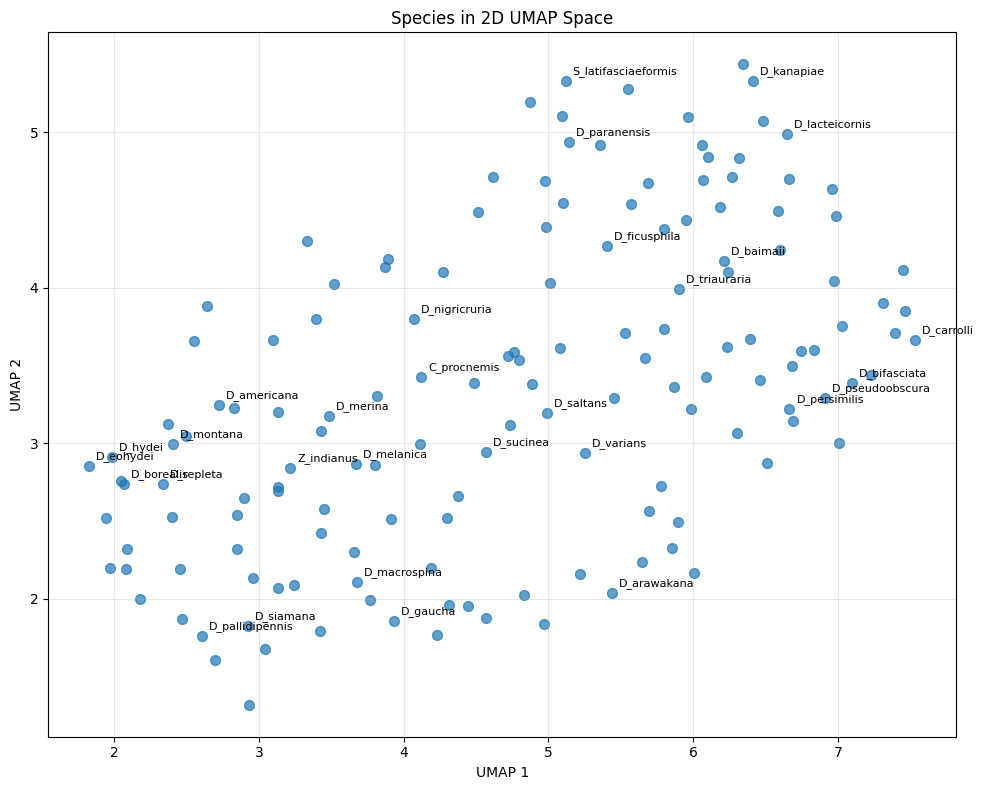

UMAP 2D embedding created with shape: (149, 2)
UMAP 3D embedding created with shape: (149, 3)


In [4]:
# Create UMAP embedding
reducer_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_2d = reducer_2d.fit_transform(trait_scaled)

reducer_3d = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_3d = reducer_3d.fit_transform(trait_scaled)

# Plot 2D UMAP
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.7, s=50)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Species in 2D UMAP Space')
plt.grid(True, alpha=0.3)

# Add species labels (every 5th to avoid overcrowding)
for i, species in enumerate(df['Species']):
    if i % 5 == 0:
        plt.annotate(species, (embedding_2d[i, 0], embedding_2d[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print(f"UMAP 2D embedding created with shape: {embedding_2d.shape}")
print(f"UMAP 3D embedding created with shape: {embedding_3d.shape}")


## Step 4: Species Clustering with HDBSCAN
This clusters species in the UMAP space using HDBSCAN, which automatically determines the number of clusters and handles noise points.
- Tries 16 different combinations of group sizes and strictness levels to find the best way to group species
- Chooses the grouping method that gives the highest "quality score" (silhouette score) and uses it to create final species groups
- Groups similar species together, identifies outliers (noise), and shows everything in a colorful scatter plot with group assignments saved to a table


Clustering species with HDBSCAN using optimized approach...
HDBSCAN clustering completed:
- Number of clusters: 2
- Number of noise points: 35
- Cluster sizes: [51 63]
- Noise percentage: 23.5%
- Validity score: 0.053 (higher is better)


c:\Users\Prof.Moses Kamya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Prof.Moses Kamya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


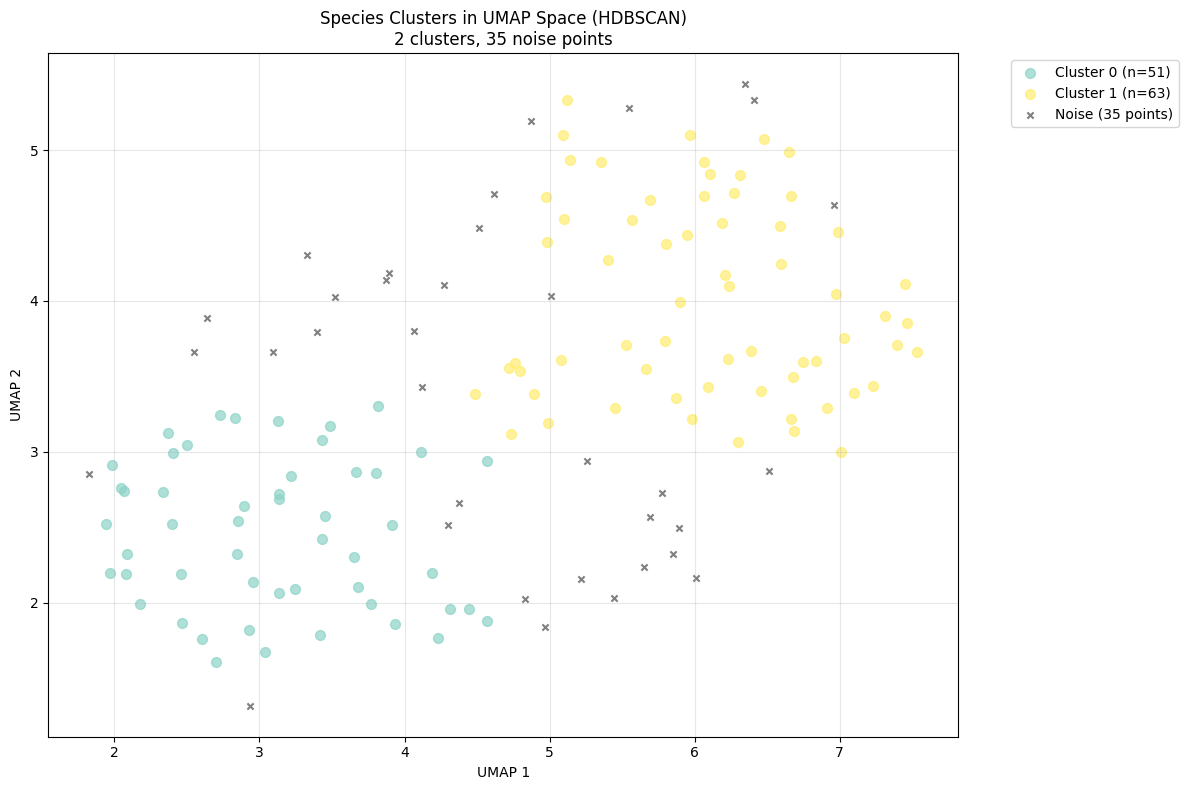


Cluster assignments saved:
          Species  Cluster    UMAP_1    UMAP_2
0     C_procnemis       -1  4.119729  3.428309
1  D_acutilabella       -1  4.832688  2.021255
2       D_affinis        1  6.744896  3.593229
3    D_albomicans        0  3.131488  2.066156
4      D_aldrichi       -1  3.394927  3.797428
5     D_americana        0  2.725522  3.246849
6     D_ananassae        1  7.008493  3.000271
7        D_anceps        0  3.128113  3.202167
8     D_anomalata        1  5.667190  3.549414
9     D_anomelani        1  6.666274  4.696061


In [14]:
# Cluster species using HDBSCAN with optimized parameters
print("Clustering species with HDBSCAN using optimized approach...")

# Use HDBSCAN with well-tuned parameters for biological data
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,        # Minimum 10 species per cluster
    min_samples=5,              # Minimum 5 neighbors for core points
    metric='euclidean',         # Distance metric
    cluster_selection_epsilon=0.1,  # Cluster selection threshold
    cluster_selection_method='eom'  # Excess of Mass method
)

# Perform clustering
species_clusters = clusterer.fit_predict(embedding_2d)

# Calculate cluster statistics
n_clusters = len(np.unique(species_clusters)) - 1  # Exclude noise (-1)
n_noise = np.sum(species_clusters == -1)
cluster_sizes = np.bincount(species_clusters[species_clusters != -1])

print(f"HDBSCAN clustering completed:")
print(f"- Number of clusters: {n_clusters}")
print(f"- Number of noise points: {n_noise}")
print(f"- Cluster sizes: {cluster_sizes}")
print(f"- Noise percentage: {n_noise/len(species_clusters)*100:.1f}%")

# Calculate HDBSCAN validity score (with proper data type conversion)
if n_clusters > 0:
    try:
        # Convert to double precision for validity calculation
        embedding_double = embedding_2d.astype(np.float64)
        validity_score = hdbscan.validity.validity_index(embedding_double, species_clusters)
        print(f"- Validity score: {validity_score:.3f} (higher is better)")
    except Exception as e:
        print(f"- Validity score: Could not calculate ({str(e)[:50]}...)")
        # Use alternative: Calinski-Harabasz index
        non_noise_mask = species_clusters != -1
        if np.sum(non_noise_mask) > 1 and len(np.unique(species_clusters[non_noise_mask])) > 1:
            ch_score = calinski_harabasz_score(embedding_2d[non_noise_mask], 
                                              species_clusters[non_noise_mask])
            print(f"- Calinski-Harabasz score: {ch_score:.3f} (higher is better)")

# Plot clusters
plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, max(n_clusters, 1)))

for cluster_id in range(n_clusters):
    mask = species_clusters == cluster_id
    plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], 
                c=[colors[cluster_id]], alpha=0.7, s=50, 
                label=f'Cluster {cluster_id} (n={np.sum(mask)})')

# Plot noise points
noise_mask = species_clusters == -1
if np.sum(noise_mask) > 0:
    plt.scatter(embedding_2d[noise_mask, 0], embedding_2d[noise_mask, 1], 
                c='black', alpha=0.5, s=20, marker='x', 
                label=f'Noise ({n_noise} points)')

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'Species Clusters in UMAP Space (HDBSCAN)\n{n_clusters} clusters, {n_noise} noise points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save cluster assignments
cluster_assignments = pd.DataFrame({
    'Species': df['Species'],
    'Cluster': species_clusters,
    'UMAP_1': embedding_2d[:, 0],
    'UMAP_2': embedding_2d[:, 1]
})

print("\nCluster assignments saved:")
print(cluster_assignments.head(10))


# Save cluster assignments
cluster_assignments = pd.DataFrame({
    'Species': df['Species'],
    'Cluster': species_clusters,
    'UMAP_1': embedding_2d[:, 0],
    'UMAP_2': embedding_2d[:, 1]
})



## Step 5: Calculate Phylogenetic Distances
This calculates pairwise phylogenetic distances between all species to later identify clusters with high internal phylogenetic diversity.


In [9]:
# Get species list from tree
tree_species = [t.name for t in tree.get_terminals()]

# Calculate phylogenetic distance matrix
phylo_dist_matrix = np.zeros((len(tree_species), len(tree_species)))

for i, sp1 in enumerate(tree_species):
    for j, sp2 in enumerate(tree_species):
        if i != j:
            phylo_dist_matrix[i, j] = tree.distance(sp1, sp2)

# Create DataFrame for easier indexing
phylo_dist_df = pd.DataFrame(phylo_dist_matrix, 
                            index=tree_species, 
                            columns=tree_species)

print(f"Phylogenetic distance matrix shape: {phylo_dist_matrix.shape}")
print(f"Distance range: {phylo_dist_matrix.min():.3f} to {phylo_dist_matrix.max():.3f}")
print(f"Mean distance: {phylo_dist_matrix.mean():.3f}")


Phylogenetic distance matrix shape: (149, 149)
Distance range: 0.000 to 121.093
Mean distance: 73.451


## Step 6: Check Phylogenetic Mixing
This calculates the mean phylogenetic distance within each cluster. Clusters with high internal phylogenetic distance are good syndrome candidates because they contain distantly related species that converged on similar phenotypes.


In [10]:
# Calculate mean phylogenetic distance within each cluster
cluster_phylo_stats = []

for cluster_id in range(n_clusters):
    cluster_mask = species_clusters == cluster_id
    cluster_species = df.loc[cluster_mask, 'Species'].tolist()
    
    if len(cluster_species) > 1:
        # Get phylogenetic distances within cluster
        cluster_distances = []
        for i, sp1 in enumerate(cluster_species):
            for j, sp2 in enumerate(cluster_species):
                if i < j and sp1 in phylo_dist_df.index and sp2 in phylo_dist_df.index:
                    dist = phylo_dist_df.loc[sp1, sp2]
                    cluster_distances.append(dist)
        
        mean_phylo_dist = np.mean(cluster_distances) if cluster_distances else 0
        
        cluster_phylo_stats.append({
            'cluster_id': cluster_id,
            'n_species': len(cluster_species),
            'species': cluster_species,
            'mean_phylo_distance': mean_phylo_dist,
            'phylo_distances': cluster_distances
        })

# Sort by phylogenetic distance (highest first)
cluster_phylo_stats.sort(key=lambda x: x['mean_phylo_distance'], reverse=True)

print("Cluster Phylogenetic Diversity (sorted by mean internal distance):")
print("=" * 60)
for stats in cluster_phylo_stats:
    print(f"Cluster {stats['cluster_id']}: {stats['n_species']} species, "
          f"mean phylo distance = {stats['mean_phylo_distance']:.3f}")
    print(f"  Species: {stats['species'][:5]}{'...' if len(stats['species']) > 5 else ''}")
    print()

# Identify candidate clusters (high phylogenetic diversity)
overall_mean_dist = phylo_dist_matrix.mean()
candidate_clusters = [stats for stats in cluster_phylo_stats 
                      if stats['mean_phylo_distance'] > overall_mean_dist]

print(f"\\nCandidate clusters (phylo distance > overall mean {overall_mean_dist:.3f}): {len(candidate_clusters)}")


Cluster Phylogenetic Diversity (sorted by mean internal distance):
Cluster 0: 51 species, mean phylo distance = 61.212
  Species: ['D_albomicans', 'D_americana', 'D_anceps', 'D_bifurca', 'D_borealis']...

Cluster 1: 63 species, mean phylo distance = 57.497
  Species: ['D_affinis', 'D_ananassae', 'D_anomalata', 'D_anomelani', 'D_arizonae']...

\nCandidate clusters (phylo distance > overall mean 73.451): 0


## Step 7: Identify Traits Driving Each Candidate Cluster
This analyzes which traits are most important for each candidate cluster by comparing within-cluster vs across-cluster variance. Traits with low within-cluster variance but high across-cluster variance are driving the syndrome.


In [11]:
# Function to identify driving traits for a cluster
def identify_driving_traits(cluster_id, trait_data, species_clusters, trait_cols):
    cluster_mask = species_clusters == cluster_id
    
    driving_traits = []
    
    for trait in trait_cols:
        # Within-cluster variance
        within_var = trait_data.loc[cluster_mask, trait].var()
        
        # Across-cluster variance (excluding this cluster)
        other_mask = species_clusters != cluster_id
        across_var = trait_data.loc[other_mask, trait].var()
        
        # Ratio: low within / high across = driving trait
        if across_var > 0:
            ratio = within_var / across_var
            driving_traits.append({
                'trait': trait,
                'within_var': within_var,
                'across_var': across_var,
                'ratio': ratio,
                'cluster_mean': trait_data.loc[cluster_mask, trait].mean(),
                'other_mean': trait_data.loc[other_mask, trait].mean()
            })
    
    # Sort by ratio (lowest = most driving)
    driving_traits.sort(key=lambda x: x['ratio'])
    return driving_traits

# Debug: Check what candidate clusters we have
print("DEBUG: Checking candidate clusters...")
print(f"Number of candidate clusters: {len(candidate_clusters)}")
print(f"Overall mean phylogenetic distance: {overall_mean_dist:.3f}")

if len(candidate_clusters) == 0:
    print("No candidate clusters found! Let's check all clusters...")
    print("\\nAll cluster phylogenetic statistics:")
    for stats in cluster_phylo_stats:
        print(f"Cluster {stats['cluster_id']}: phylo distance = {stats['mean_phylo_distance']:.3f}")
    
    # Use top 2 clusters regardless of phylogenetic distance
    print("\\nUsing top 2 clusters by phylogenetic distance...")
    candidate_clusters = cluster_phylo_stats[:2]

# Analyze each candidate cluster
print("\\nDRIVING TRAITS ANALYSIS")
print("=" * 50)

for stats in candidate_clusters:
    cluster_id = stats['cluster_id']
    print(f"\\nCluster {cluster_id} (phylo distance: {stats['mean_phylo_distance']:.3f})")
    print(f"Species: {stats['species']}")
    print("-" * 40)
    
    driving_traits = identify_driving_traits(cluster_id, trait_data_clean, species_clusters, trait_cols)
    
    if len(driving_traits) > 0:
        print("Top 5 driving traits:")
        for i, trait_info in enumerate(driving_traits[:5]):
            print(f"  {i+1}. {trait_info['trait']}")
            print(f"     Ratio: {trait_info['ratio']:.3f} (within/across variance)")
            print(f"     Cluster mean: {trait_info['cluster_mean']:.3f}")
            print(f"     Other mean: {trait_info['other_mean']:.3f}")
            print()
    else:
        print("No driving traits found for this cluster.")


DEBUG: Checking candidate clusters...
Number of candidate clusters: 0
Overall mean phylogenetic distance: 73.451
No candidate clusters found! Let's check all clusters...
\nAll cluster phylogenetic statistics:
Cluster 0: phylo distance = 61.212
Cluster 1: phylo distance = 57.497
\nUsing top 2 clusters by phylogenetic distance...
\nDRIVING TRAITS ANALYSIS
\nCluster 0 (phylo distance: 61.212)
Species: ['D_albomicans', 'D_americana', 'D_anceps', 'D_bifurca', 'D_borealis', 'D_ercepeae', 'D_falleni', 'D_formosana', 'D_fulvimacula', 'D_funebris', 'D_gaucha', 'D_hydei', 'D_hypocausta', 'D_immigrans', 'D_kanekoi', 'D_kepulauna', 'D_lacicola', 'D_littoralis', 'D_lummei', 'D_macrospina', 'D_melanica', 'D_meridiana', 'D_meridionalis', 'D_merina', 'D_montana', 'D_nasuta', 'D_neonasuta', 'D_nigrohydei', 'D_novamexicana', 'D_pallidipennis', 'D_paramelanica', 'D_parthenogenetica', 'D_prolongata', 'D_quadrilineata', 'D_quinaria', 'D_repleta', 'D_repletoides', 'D_robusta', 'D_siamana', 'D_sordidula', 'D

## Step 8: Visualize Driving Traits for Candidate Clusters
This creates boxplots showing the distribution of driving traits within each candidate cluster compared to all other species.


\nVisualizing Cluster 0 driving traits
Species in cluster: ['D_albomicans', 'D_americana', 'D_anceps', 'D_bifurca', 'D_borealis', 'D_ercepeae', 'D_falleni', 'D_formosana', 'D_fulvimacula', 'D_funebris', 'D_gaucha', 'D_hydei', 'D_hypocausta', 'D_immigrans', 'D_kanekoi', 'D_kepulauna', 'D_lacicola', 'D_littoralis', 'D_lummei', 'D_macrospina', 'D_melanica', 'D_meridiana', 'D_meridionalis', 'D_merina', 'D_montana', 'D_nasuta', 'D_neonasuta', 'D_nigrohydei', 'D_novamexicana', 'D_pallidipennis', 'D_paramelanica', 'D_parthenogenetica', 'D_prolongata', 'D_quadrilineata', 'D_quinaria', 'D_repleta', 'D_repletoides', 'D_robusta', 'D_siamana', 'D_sordidula', 'D_sucinea', 'D_sulfurigaster', 'D_virilis', 'S_lebanonensis', 'Z_davidi', 'Z_gabonicus', 'Z_ghesquierei', 'Z_indianus', 'Z_kolodkinae', 'Z_taronus', 'Z_tuberculatus']


C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_27704\3256577493.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_27704\3256577493.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_27704\3256577493.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_277

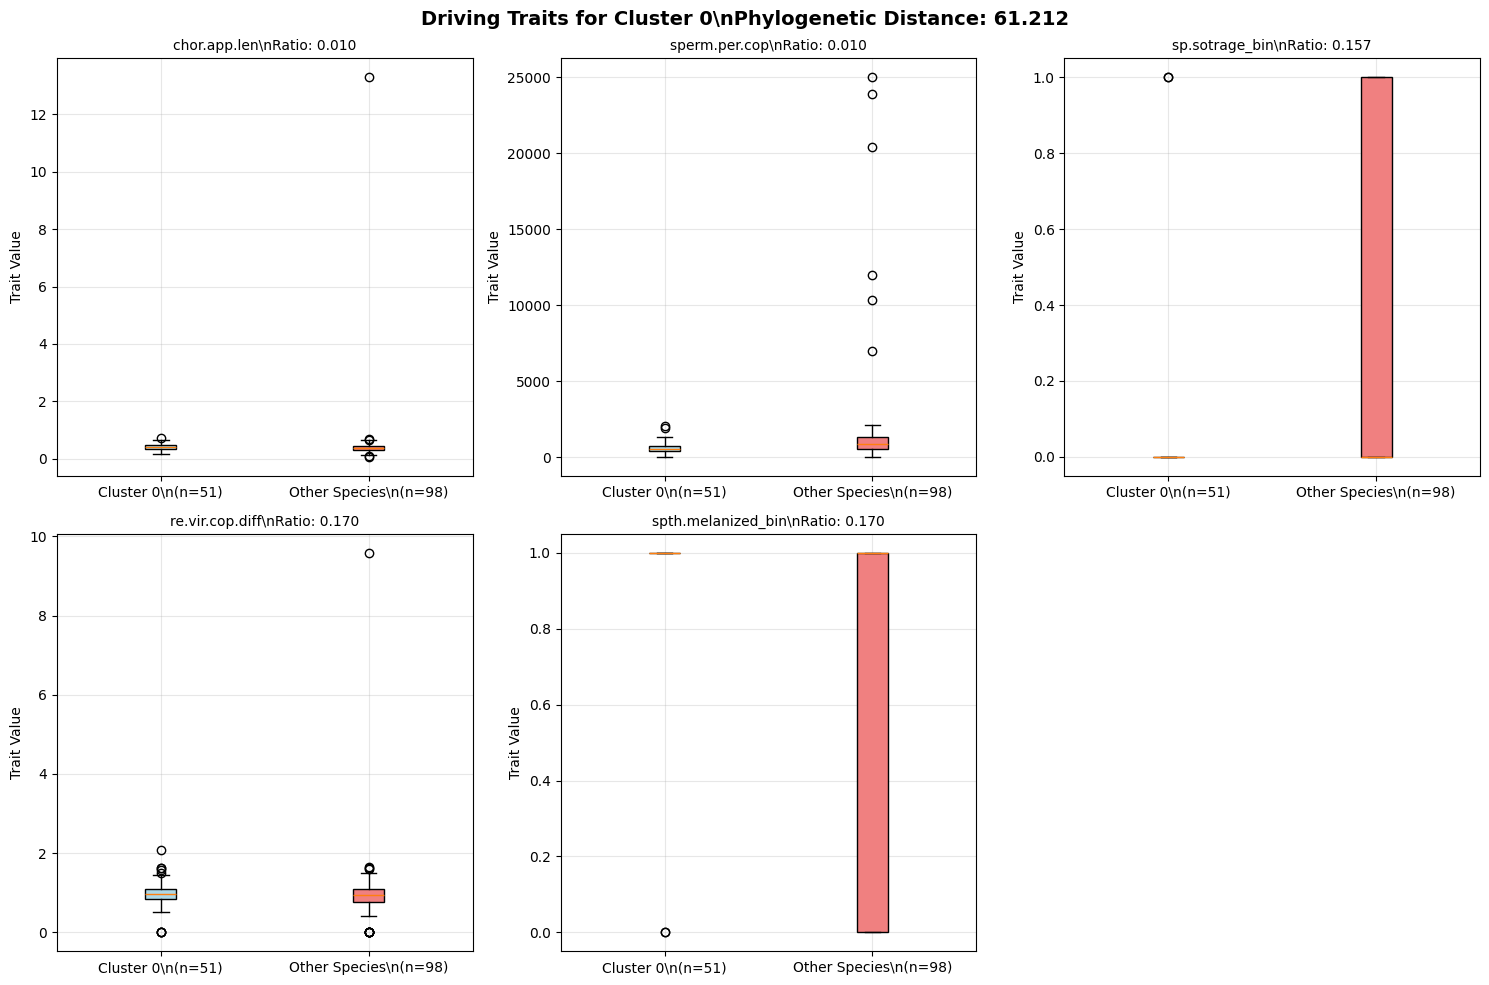

\nVisualizing Cluster 1 driving traits
Species in cluster: ['D_affinis', 'D_ananassae', 'D_anomalata', 'D_anomelani', 'D_arizonae', 'D_atripex', 'D_austrosaltans', 'D_azteca', 'D_baimaii', 'D_bakoue', 'D_barbarae', 'D_biarmipes', 'D_bicornuta', 'D_bifasciata', 'D_bipectinata', 'D_birchii', 'D_bocqueti', 'D_bunnanda', 'D_burlai', 'D_busckii', 'D_carrolli', 'D_chauvacae', 'D_equinoxialis', 'D_ficusphila', 'D_greeni', 'D_guanche', 'D_gunungcola', 'D_jambulina', 'D_kikkawai', 'D_lacteicornis', 'D_lutescens', 'D_malagassya', 'D_malerkotliana', 'D_mauritiana', 'D_mayaguana', 'D_melanogaster', 'D_monieri', 'D_nebulosa', 'D_nikananu', 'D_pallidosa', 'D_pandora', 'D_parabipectinata', 'D_paranensis', 'D_paulistorum', 'D_persimilis', 'D_pseudoobscura', 'D_pseudotakahashii', 'D_punjabiensis', 'D_rhopaloa', 'D_rufa', 'D_saltans', 'D_sechellia', 'D_seguyi', 'D_simulans', 'D_takahashii', 'D_tani', 'D_triauraria', 'D_tropicalis', 'D_truncata', 'D_tsacasi', 'D_watanabei', 'D_willistoni', 'S_latifasciae

C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_27704\3256577493.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_27704\3256577493.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_27704\3256577493.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_277

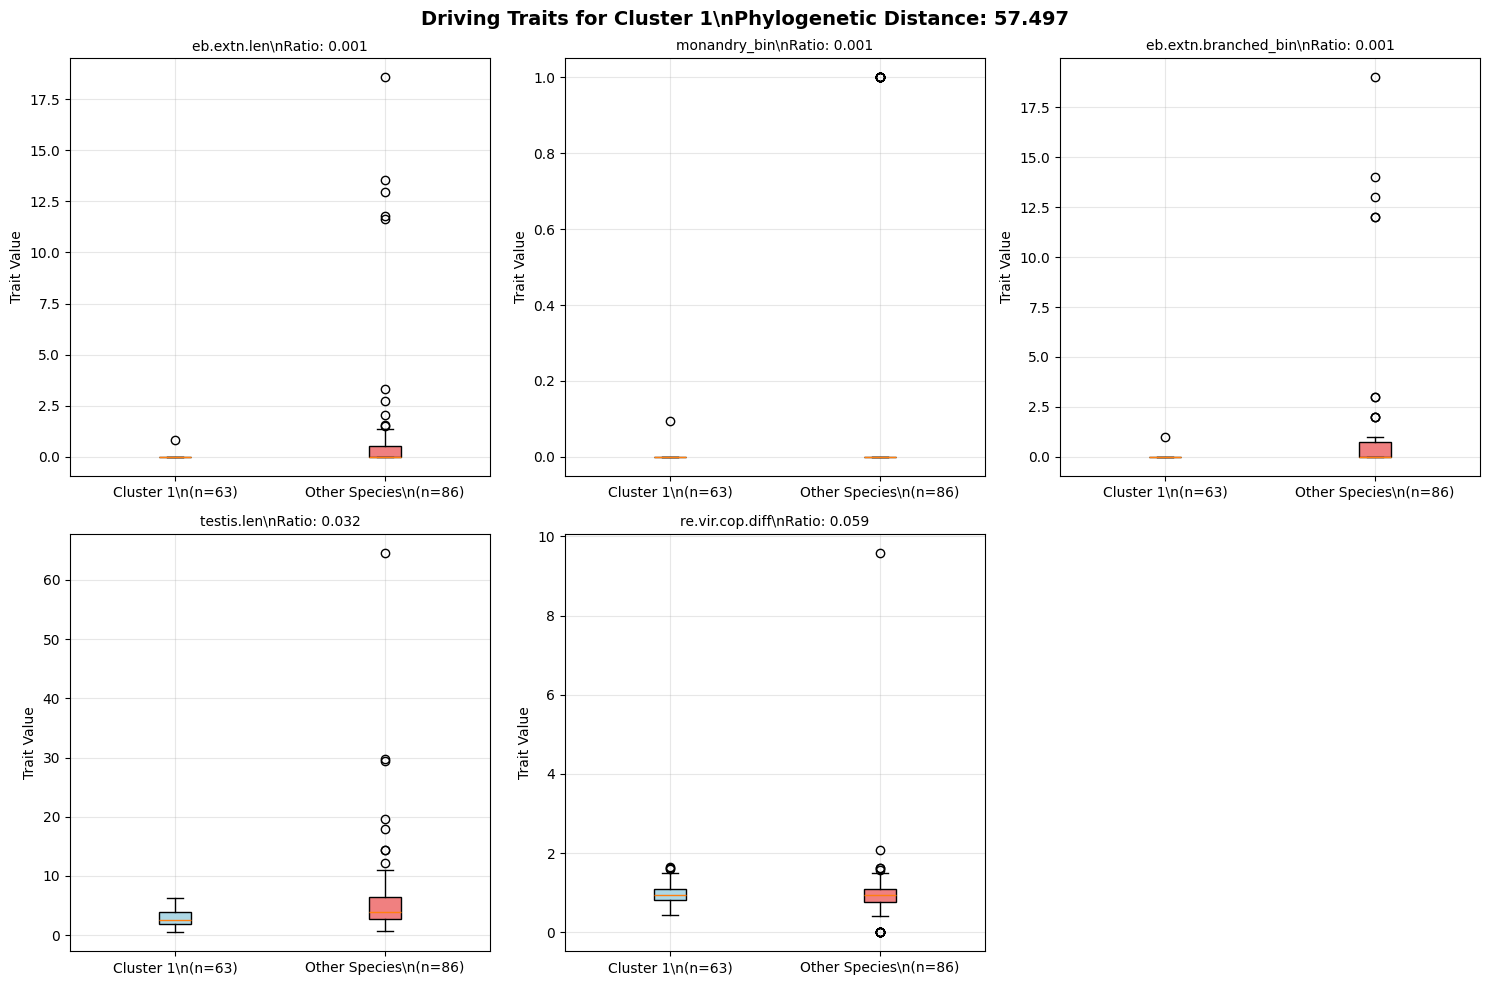

\nAnalysis complete! Candidate clusters identified with driving traits.


In [12]:
# Create visualizations for driving traits
for stats in candidate_clusters[:2]:  # Show top 2 candidate clusters
    cluster_id = stats['cluster_id']
    cluster_species = stats['species']
    
    print(f"\\nVisualizing Cluster {cluster_id} driving traits")
    print(f"Species in cluster: {cluster_species}")
    
    driving_traits = identify_driving_traits(cluster_id, trait_data_clean, species_clusters, trait_cols)
    top_traits = [t['trait'] for t in driving_traits[:5]]
    
    # Create subplots for top 5 driving traits
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, trait in enumerate(top_traits):
        ax = axes[i]
        
        # Prepare data for boxplot
        cluster_data = trait_data_clean.loc[species_clusters == cluster_id, trait]
        other_data = trait_data_clean.loc[species_clusters != cluster_id, trait]
        
        # Create boxplot
        data_to_plot = [cluster_data, other_data]
        labels = [f'Cluster {cluster_id}\\n(n={len(cluster_data)})', 
                 f'Other Species\\n(n={len(other_data)})']
        
        bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][1].set_facecolor('lightcoral')
        
        ax.set_title(f'{trait}\\nRatio: {driving_traits[i]["ratio"]:.3f}', fontsize=10)
        ax.set_ylabel('Trait Value')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplot
    axes[5].set_visible(False)
    
    plt.suptitle(f'Driving Traits for Cluster {cluster_id}\\n'
                 f'Phylogenetic Distance: {stats["mean_phylo_distance"]:.3f}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\\nAnalysis complete! Candidate clusters identified with driving traits.")


## Summary

This analysis identified candidate syndromes by:

1. **Clustering species** in UMAP space using HDBSCAN
2. **Calculating phylogenetic diversity** within each cluster
3. **Identifying candidate clusters** with high internal phylogenetic distance
4. **Finding driving traits** with low within-cluster variance and high across-cluster variance
5. **Visualizing trait distributions** to confirm syndrome patterns

